In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [6]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Importing the names data
# with open("names.txt", "r") as f:
#   words  = f.read().splitlines()
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [280]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(142)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182577, 3]) torch.Size([182577])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22776, 3]) torch.Size([22776])


## My Tweaks I'm still working on

In [7]:
emb_range = range(4,10)
hidden_layer_range = range(1,4)
neurons_range = range(50, 301, 50)
hidden_layer_sizes = [[neuron]*n_layers for n_layers in hidden_layer_range for neuron in neurons_range]

epoch = 100000

In [ ]:
# --- Seed generator ---
g = torch.Generator().manual_seed(2147483647)

# --- Storage ---
results = []
best_config = {"val_loss": float('inf')}

for embs in emb_range:
  C = torch.randn((27, embs), generator=g)
  input_size = embs * block_size
  output_size = len(stoi)
  sizes =  [[input_size, *hidden_layer_size,output_size] for hidden_layer_size in hidden_layer_sizes]

  for size in sizes:
    biases = [torch.randn(i, generator=g) for i in size[1:]]
    Weights = [torch.randn(size[i], size[i+1], generator=g)* (5/size[i])**0.5 for i in range(len(size)-1)]

    params = [C, *Weights,*biases]
    # params_count = sum(p.nelement() for p in params)

    for p in params:
      p.requires_grad = True

    for i in range(epoch):

      # minibatch construct
      ix = torch.randint(0, Xtr.shape[0], (32,))

      # forward pass
      emb = C[Xtr[ix]] # (32, 3, 2)
      a = emb.view(-1, input_size)
      for w,b in zip(Weights,biases):
        a = torch.tanh(a @ w + b)

      logits = a #(32, 27)
      loss = F.cross_entropy(logits, Ytr[ix])
      # print(loss.item())
      

      # backward pass
      for p in params:
        p.grad = None
      loss.backward()

      # update
      #lr = lrs[i]
      lr = 0.1 if i < (epoch/2) else 0.01
      for p in params:
        p.data += -lr * p.grad

    config_id = f"emb{embs}_hid{size[1:-1]}"


    with torch.no_grad():
      # training loss
      emb = C[Xtr]
      a = emb.view(-1, input_size)
      for w,b in zip(Weights[:-1], biases[:-1]):
          a = torch.tanh(a @ w + b)
      logits = a @ Weights[-1] + biases[-1]
      train_loss = F.cross_entropy(logits, Ytr)

      # validation loss
      emb = C[Xdev]
      a = emb.view(-1, input_size)
      for w,b in zip(Weights[:-1], biases[:-1]):
          a = torch.tanh(a @ w + b)
      logits = a @ Weights[-1] + biases[-1]
      val_loss = F.cross_entropy(logits, Ydev)

    print(f"Emb: {embs} | Hidden: {size[1:-1]} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
    print("================")
    print("")
    # Count parameters
    param_count = sum(p.nelement() for p in params)

    # Store result
    result = {
        "embedding_size": embs,
        "hidden_layers": size[1:-1],
        "param_count": param_count,
        "train_loss": train_loss,
        "val_loss": val_loss
    }
    results.append(result)

    # Track best config
    if val_loss < best_config["val_loss"]:
        best_config = result.copy()
    
# --- After all runs ---
import pandas as pd
df_results = pd.DataFrame(results)
print("\n=== Best Configuration ===")
print(best_config)



In [ ]:
# --- After all runs ---
import pandas as pd
df_results = pd.DataFrame(results)
print("\n=== Best Configuration ===")
print(best_config)

In [25]:
# df_results


## The Tweaks i went with

In [ ]:


# Good values = [10, 300, 2, 500000 epoch decay of 0.01, .001, 0.0001]
# Good values = [12, 300, 2, 600000 epoch lr_decay of 0.01, .001, 0.0001, 0.00001]
emb_dim, neurons, hidden_layers = 15, 300, 2
input_size = emb_dim * block_size
output_size = len(stoi) 
hidden_layer_size = [neurons for _ in range(hidden_layers)]
sizes =  [input_size, *hidden_layer_size,output_size]
print(f'sizes: {sizes}')

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_dim), generator=g)


biases = [torch.randn(i, generator=g) for i in sizes[1:]]
Weights = [torch.randn(sizes[i], sizes[i+1], generator=g) for i in range(len(sizes)-1)]
parameters = [C, *biases, *Weights]


sizes: [45, 300, 300, 27]


In [282]:
sum(p.nelement() for p in parameters) # number of parameters in total

112632

In [283]:
for p in parameters:
  p.requires_grad = True

In [284]:
# Determinng the right learning rate 

lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9986, 0.9993, 1.0000])

In [285]:
lri = []
lossi = []
stepi = []

In [ ]:
epoch = 200000
for i in range(epoch):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward ass
  emb = C[Xtr[ix]] # (32, 3, 2)
  a = emb.view(-1, input_size)
  for w,b in zip(Weights[:-1],biases[:-1]):
    a = torch.tanh(a @ w + b)

  logits = a @ Weights[-1] + biases[-1] #(32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = 0.00001 
  lr = 0.00001 if i < (epoch/2) else 0.000001
  for p in parameters:
    # lr = lrs[i]
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # stepi.append(i)
  # lossi.append(loss.log10().item())

#print(loss.item())

1.7724831104278564
1.9390089511871338
2.693925619125366
2.011460304260254
2.3071212768554688
2.0630686283111572
2.423285961151123
1.5378222465515137
1.9042168855667114
1.7519538402557373
2.4849460124969482
1.9029457569122314
1.8440090417861938
1.999924659729004
2.2616095542907715
2.184508800506592
1.8708076477050781
1.819148302078247
2.0907695293426514
2.057293653488159
1.9720697402954102
2.3515820503234863
2.365380048751831
1.7645535469055176
2.2406888008117676
1.821793794631958
2.2621538639068604
1.8496671915054321
1.8318488597869873
2.1088168621063232
1.8877438306808472
2.013094663619995
1.8481225967407227
1.701428771018982
2.0696194171905518
2.0277278423309326
1.7580580711364746
2.3216757774353027
2.125014066696167
2.0069570541381836
2.052450180053711
2.25602388381958
2.2264227867126465
2.5865981578826904
2.308696746826172
2.3832108974456787
2.082965612411499
2.242579221725464
2.4424562454223633
1.9698412418365479
1.9100260734558105
2.159637928009033
1.902008056640625
2.10471463203

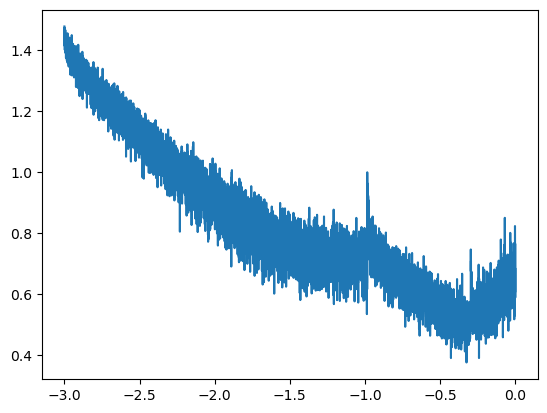

In [155]:
# plt.plot(stepi, lossi)
plt.plot(lri, lossi)

In [ ]:


 # training loss
emb = C[Xtr] # (32, 3, 2)
a = emb.view(-1, input_size)
for w,b in zip(Weights[:-1],biases[:-1]):
    a = torch.tanh(a @ w + b)

logits = a @ Weights[-1] + biases[-1] #(32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.0561962127685547


In [ ]:


 # validation loss
emb = C[Xdev] # (32, 3, 2)
a = emb.view(-1, input_size)
for w,b in zip(Weights[:-1],biases[:-1]):
    a = torch.tanh(a @ w + b)

logits = a @ Weights[-1] + biases[-1] #(32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1571309566497803


In [295]:
# test loss

emb = C[Xte] # (32, 3, 2)
a = emb.view(-1, input_size)
for w,b in zip(Weights[:-1],biases[:-1]):
    a = torch.tanh(a @ w + b)

logits = a @ Weights[-1] + biases[-1] #(32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.1549148559570312


In [316]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    # print(context)
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        
        a = emb.view(1, -1)
        for w,b in zip(Weights[:-1],biases[:-1]):
            a = torch.tanh(a @ w + b)
        logits = a @ Weights[-1] + biases[-1]
        # print(logits)
        probs = F.softmax(logits, dim=1)
        # print(probs)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # print(ix)
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amillivia.
jari.
reity.
skanden.
jazhnen.
delynn.
jarqui.
nellara.


chaiivan.
legypt.
bron.
cadeen.
thorline.
liveni.
wazell.
dearyxie.
kael.
duraylen.
edi.
